In [1]:
month = "June"
file_path = "data/filtered_pred_"+month+"2024.csv"

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as spark_sum, col, hour, concat_ws, to_date, date_format

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("BusTicketDemandForecasting") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load CSV data into Spark DataFrame

data = spark.read.csv(file_path, header=True, inferSchema=True)

# Group data by "DATE_HOUR" and aggregate demand per hour
data_grouped = data.groupBy("DATE_HOUR", "ROUTE_NAME").agg(
    spark_sum("NO_OF_ADULT").alias("NO_OF_ADULT"),
    spark_sum("NO_OF_CHILD").alias("NO_OF_CHILD")
)

# Convert DATE_HOUR to timestamp (if not already)
data_grouped = data_grouped.withColumn('DATE_HOUR', to_date(col('DATE_HOUR')))

# Show sample of data
data_grouped.show(5)


your 131072x1 screen size is bogus. expect trouble
25/01/13 08:54:53 WARN Utils: Your hostname, J4Hp resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/01/13 08:54:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/13 08:54:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+----------+-----------+-----------+
| DATE_HOUR|ROUTE_NAME|NO_OF_ADULT|NO_OF_CHILD|
+----------+----------+-----------+-----------+
|2024-06-20| 5C Violet|         68|          0|
|2024-06-13|     1666F|         55|          0|
|2024-06-12|     A1603|         70|          0|
|2024-06-10|     1029A|          2|          0|
|2024-06-14| 9C Orange|          5|          0|
+----------+----------+-----------+-----------+
only showing top 5 rows



In [3]:
from pyspark.sql.functions import hour, dayofweek, month

# Extract additional features like hour, day of the week, and month
data_with_features = data_grouped.withColumn("hour", hour(col("DATE_HOUR"))) \
    .withColumn("day_of_week", dayofweek(col("DATE_HOUR"))) \
    .withColumn("month", month(col("DATE_HOUR")))

# Show the transformed dataset
data_with_features.show(5)


+----------+----------+-----------+-----------+----+-----------+-----+
| DATE_HOUR|ROUTE_NAME|NO_OF_ADULT|NO_OF_CHILD|hour|day_of_week|month|
+----------+----------+-----------+-----------+----+-----------+-----+
|2024-06-20| 5C Violet|         68|          0|   0|          5|    6|
|2024-06-13|     1666F|         55|          0|   0|          5|    6|
|2024-06-12|     A1603|         70|          0|   0|          4|    6|
|2024-06-10|     1029A|          2|          0|   0|          2|    6|
|2024-06-14| 9C Orange|          5|          0|   0|          6|    6|
+----------+----------+-----------+-----------+----+-----------+-----+
only showing top 5 rows



In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Index and one-hot encode ROUTE_NAME
route_indexer = StringIndexer(inputCol="ROUTE_NAME", outputCol="ROUTE_NAME_INDEX")
route_encoder = OneHotEncoder(inputCol="ROUTE_NAME_INDEX", outputCol="ROUTE_NAME_OHE")

# Assemble the features into a single vector
assembler = VectorAssembler(
    inputCols=["hour", "day_of_week", "month", "ROUTE_NAME_OHE", "NO_OF_ADULT", "NO_OF_CHILD"], 
    outputCol="features"
)

# Define the pipeline
pipeline = Pipeline(stages=[route_indexer, route_encoder, assembler])

# Fit the pipeline and transform the data
model_data = pipeline.fit(data_with_features).transform(data_with_features)

# Show the resulting data
model_data.select("DATE_HOUR", "features", "NO_OF_ADULT", "NO_OF_CHILD").show(5)


25/01/13 08:55:11 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+----------+--------------------+-----------+-----------+
| DATE_HOUR|            features|NO_OF_ADULT|NO_OF_CHILD|
+----------+--------------------+-----------+-----------+
|2024-06-20|(1221,[1,2,18,121...|         68|          0|
|2024-06-13|(1221,[1,2,431,12...|         55|          0|
|2024-06-12|(1221,[1,2,97,121...|         70|          0|
|2024-06-10|(1221,[1,2,245,12...|          2|          0|
|2024-06-14|(1221,[1,2,8,1219...|          5|          0|
+----------+--------------------+-----------+-----------+
only showing top 5 rows



In [5]:
from pyspark.ml.regression import RandomForestRegressor

# Define the regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="NO_OF_ADULT", maxDepth=5)

# Split data into training and testing sets
train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=1234)

# Train the model
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Show predictions
predictions.select("DATE_HOUR", "NO_OF_ADULT", "prediction").show(5)


ERROR:root:Exception while sending command.                         (0 + 1) / 1]
Traceback (most recent call last):
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetw

Py4JError: An error occurred while calling o180.fit

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluator
evaluator = RegressionEvaluator(labelCol="NO_OF_ADULT", predictionCol="prediction", metricName="rmse")

# Calculate RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# You can also compute MAE and R2 using similar evaluators


Root Mean Squared Error (RMSE): 25.324231394726162


In [9]:
# %% [After predictions are made]

import matplotlib.pyplot as plt
import pandas as pd


# Convert Spark DataFrame to Pandas DataFrame for plotting
predictions_pd = predictions.select("DATE_HOUR", "NO_OF_ADULT", "prediction").toPandas()

# Convert the 'DATE_HOUR' column to datetime format
predictions_pd['DATE_HOUR'] = pd.to_datetime(predictions_pd['DATE_HOUR'])

# Set 'DATE_HOUR' as the index for easier plotting
predictions_pd.set_index('DATE_HOUR', inplace=True)

# Plot Actual vs Predicted values as continuous lines
plt.figure(figsize=(14, 7))
plt.plot(predictions_pd.index, predictions_pd['NO_OF_ADULT'], label='Actual NO_OF_ADULT', color='blue', linestyle='-', linewidth=2)
plt.plot(predictions_pd.index, predictions_pd['prediction'], label='Predicted NO_OF_ADULT', color='red', linestyle='-', linewidth=2)

# Add labels and title
plt.title('Actual vs Predicted Bus Ticket Demand (Adults)', fontsize=16)
plt.xlabel('Date and Hour', fontsize=12)
plt.ylabel('Number of Adults', fontsize=12)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot

plt.show()


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is em

Py4JError: functions does not exist in the JVM

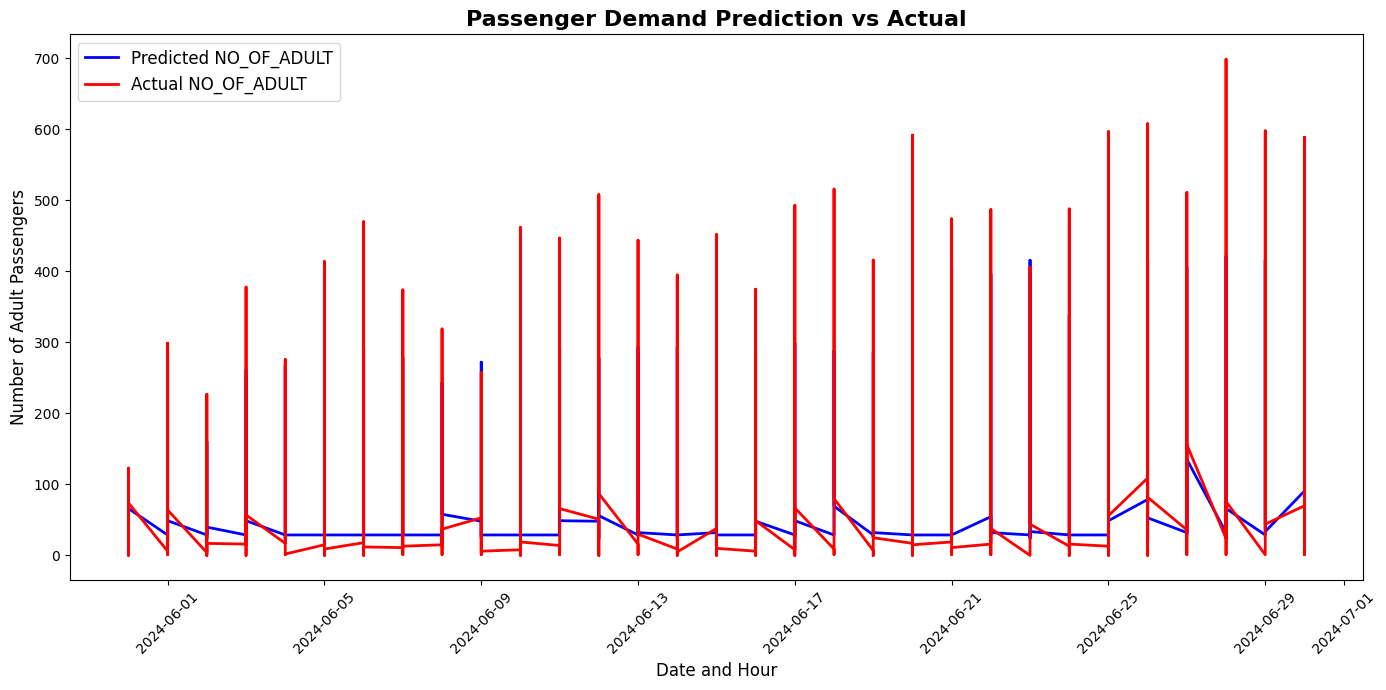

In [8]:
# Improved Plot for Actual vs Predicted Values
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for plotting
predictions_pd = predictions.select("DATE_HOUR", "NO_OF_ADULT", "prediction").toPandas()

# Convert the 'DATE_HOUR' column to datetime format
predictions_pd['DATE_HOUR'] = pd.to_datetime(predictions_pd['DATE_HOUR'])

# Set 'DATE_HOUR' as the index for easier plotting
predictions_pd.set_index('DATE_HOUR', inplace=True)

# Plot Actual vs Predicted values with enhanced visuals
plt.figure(figsize=(14, 7))

# Plot lines for actual and predicted values
plt.plot(predictions_pd.index, predictions_pd['prediction'], label='Predicted NO_OF_ADULT', color='blue', linestyle='-', linewidth=2)
plt.plot(predictions_pd.index, predictions_pd['NO_OF_ADULT'], label='Actual NO_OF_ADULT', color='red', linestyle='-', linewidth=2)

# Add labels and title
plt.title('Passenger Demand Prediction vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date and Hour', fontsize=12)
plt.ylabel('Number of Adult Passengers', fontsize=12)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, fontsize=10)

# Add a legend
plt.legend(fontsize=12)

# Use tight layout for better spacing
plt.tight_layout()

# Save the plot to a file or display
# Save as PNG (optional)
plt.show()
